<a href="https://colab.research.google.com/github/jmgang/G7Sprint1Deliverable/blob/main/Copy_of_Project_s1_group7_teaching_hanna_how_to_swim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Transaction Data for Segmentation

## Introduction

In this analysis, we will explore a dataset that contains transactional information, including details about account holders, transaction amounts, timestamps, and various attributes. Our goal is to gain valuable insights into the data by addressing a series of business questions. These questions will help us understand the patterns, trends, and relationships within the dataset, ultimately enabling us to make data-driven decisions.

The dataset comprises 111,877 entries with 12 columns, including information about account numbers, gender, city, job, date of birth, transaction details, and more. Some of the key business questions we aim to answer include:

1. Do the customers have different spending habits in terms of the following demographics?
  - Gender
  - Age group
  - Job
  - City
2. Which cities are the top spenders? How do these relate with the city's population?
3. Are there any trends and patterns on amount spent based on transaction time? Are there specific groups that spend more on certain time of the year?
4. Are there any outliers in the transactions that require special attention?
5. Where do customers tend to spend more based on transaction categories?
6. **k-MEANS QUESTION HERE**

Through a comprehensive analysis, we aim to provide valuable insights that can inform marketing strategies, customer segmentation, and fraud detection measures, among other applications.

<!--
## Original questions
1. How much is the total amount of transactions per account holder?
2. What is the total transaction amount per city, and how does it relate to city population?
3. What are the spending habits between urban and rural cities, and how do we identify urban and rural areas?
4. What is the mean and median amount spent by customers within a specified time frame?
5. How can we convert UNIX timestamps to a human-readable time series for time-based analysis?
6. Are there any outliers in the transactions that require special attention?
7. Where do customers tend to spend more based on transaction categories?
-->

## Data Preprocessing

In [2]:
# Load packages required
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reference: https://python-charts.com/matplotlib/styles/
plt.style.use("fivethirtyeight")
plt.rcParams['axes.grid'] = False

# Read data to be used
df = pd.read_csv("http://raw.githubusercontent.com/jabbbyyy/esk-datasets/main/cc_fraud_dirty.csv")
covid = pd.read_csv("https://raw.githubusercontent.com/imjbmkz/G7Sprint1Deliverable/main/ph_covid_data_susbet.csv", parse_dates=["date"])

In [3]:
# Print the details of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cc_num     111877 non-null  float64
 1   gender     111877 non-null  object 
 2   city       111877 non-null  object 
 3   city_pop   111877 non-null  object 
 4   job        103427 non-null  object 
 5   dob        111877 non-null  object 
 6   acct_num   111877 non-null  int64  
 7   acct_num2  111877 non-null  int64  
 8   trans_num  111877 non-null  object 
 9   unix_time  111877 non-null  int64  
 10  category   103318 non-null  object 
 11  amt        111877 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 10.2+ MB


In [4]:
def get_age_group(age):
  """ This function returns the age group based on
      NIH
  """
  # Source: https://www.nih.gov/nih-style-guide/age
  if age <= 12:
    return "children"
  elif age <= 17:
    return "adolescents"
  elif age <= 64:
    return "adults"
  else:
    return "older adults"

def get_generation(birthdate):
  """ This function returns the generation based on
      Beresford Research
  """
  birth_year = birthdate.year
  # Source: https://www.beresfordresearch.com/age-range-by-generation/
  if 1997 <= birth_year <= 2012:
    return "Gen Z"
  elif 1981 <= birth_year <= 1996:
    return "Millennials"
  elif 1965 <= birth_year <= 1980:
      return "Gen X"
  elif 1955 <= birth_year <= 1964:
      return "Boomers II"
  elif 1946 <= birth_year <= 1954:
      return "Boomers I"
  elif 1928 <= birth_year <= 1945:
      return "Post War"
  elif 1922 <= birth_year <= 1927:
      return "WWII"
  else:
      return "Unknown"

##Data Cleaning and Preparation Summary

The research team performed several important steps to prepare and clean the dataset for analysis:

Date of Birth (DOB) Formatting: Ensured consistent formatting of date of birth (DOB) information.

Age Calculation: Calculated the age of individuals in the dataset based on their date of birth.

Age Group and Generation: Categorized individuals into age groups and identified their generational cohorts.

Column Standardization: Ensured consistency in gender labels and formatted population data.

Transaction Timestamp: Transformed transaction timestamps for ease of analysis.

Amount Conversion: Converted transaction amounts to a common currency.

Irrelevant Columns Removal: Removed columns that do not contribute to the analysis such as the acct_num2 and unix_time columns

In [5]:
# Create a copy of the dataframe and clean the columns
df_cleaned = df.copy()

# Format dob column to datetime
df_cleaned["dob"] = pd.to_datetime(df_cleaned["dob"], format="%d/%m/%Y")

# Get age, age group, and generation
df_cleaned.insert(6, "age", (pd.Timestamp.now() - df_cleaned["dob"]) // pd.Timedelta(days=365.2425))
df_cleaned.insert(7, "age_group", df_cleaned["age"].map(get_age_group))
df_cleaned.insert(8, "generation", df_cleaned["dob"].map(get_generation))

# Clean and standardize other columns
df_cleaned["city_pop"] = df_cleaned["city_pop"].replace("people|,", "", regex=True).astype(int)
df_cleaned["gender"] = df_cleaned["gender"].replace({"M": "Male", "F": "Female"})
df_cleaned["trans_timestamp"] = pd.to_datetime(df_cleaned["unix_time"], unit="s")
df_cleaned["trans_date"] = df_cleaned["trans_timestamp"].dt.date

# Clean amt and convert to pesos
df_cleaned["amt"] = df_cleaned["amt"].replace("\$", "", regex=True).astype(float)
df_cleaned['amt']= df_cleaned['amt'] * 56.82

# Drop irrelevant columns
df_cleaned.drop(["acct_num2", "unix_time"], axis=1, inplace=True)

# Show data info
display(df_cleaned.info())

# Show first few rows of the data
display(df_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   cc_num           111877 non-null  float64       
 1   gender           111877 non-null  object        
 2   city             111877 non-null  object        
 3   city_pop         111877 non-null  int64         
 4   job              103427 non-null  object        
 5   dob              111877 non-null  datetime64[ns]
 6   age              111877 non-null  int64         
 7   age_group        111877 non-null  object        
 8   generation       111877 non-null  object        
 9   acct_num         111877 non-null  int64         
 10  trans_num        111877 non-null  object        
 11  category         103318 non-null  object        
 12  amt              111877 non-null  float64       
 13  trans_timestamp  111877 non-null  datetime64[ns]
 14  trans_date       111

None

,cc_num,gender,city,city_pop,job,dob,age,age_group,generation,acct_num,trans_num,category,amt,trans_timestamp,trans_date
0,6.760000e+11,Male,Dasmarinas,659019,Chartered loss adjuster,1958-12-12,64,adults,Boomers II,798000000000,a72eaa86b043eed95b25bbb25b3153a1,shopping_net,3913.7616,2020-02-10 05:53:31,2020-02-10
1,3.520000e+15,Male,Digos,169393,"Administrator, charities/voluntary organisations",1970-08-31,53,adults,Gen X,968000000000,060d12f91c13871a13963041736a4702,entertainment,2844.4092,2020-05-31 05:29:28,2020-05-31
2,4.140000e+18,Male,Calapan,133893,Financial controller,1953-07-23,70,older adults,Boomers I,628000000000,18aafb6098ab0923886c0ac83592ef8d,food_dining,5991.1008,2020-03-29 05:52:37,2020-03-29
3,4.870000e+15,Male,San Fernando,121812,NaN,1964-07-18,59,adults,Boomers II,863000000000,45bbe714e51ab8a375454d39a190b0cb,food_dining,2193.8202,2021-02-11 17:15:04,2021-02-11
4,4.720000e+15,Male,Laoag,111125,Dance movement psychotherapist,1954-01-11,69,older adults,Boomers I,257000000000,c20ee88b451f637bc6893b7460e9fee0,gas_transport,4698.4458,2020-09-28 08:35:59,2020-09-28


## EDA

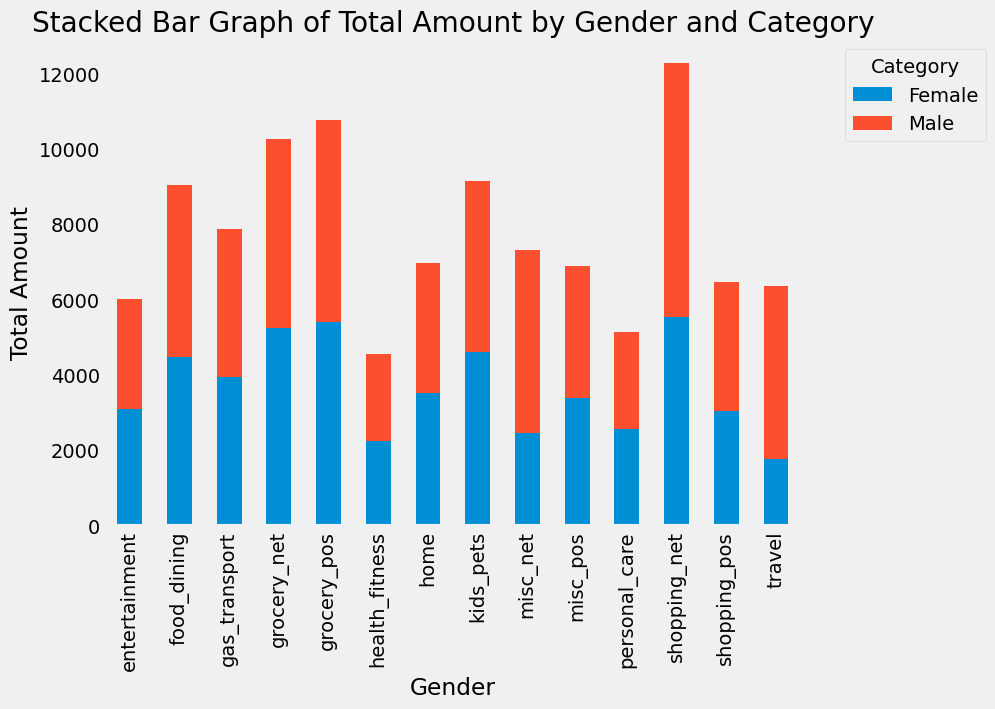

In [6]:
# Pivot the DataFrame to create a suitable format for a stacked bar plot
pivot_df = df_cleaned.pivot_table(index="category", columns="gender", values="amt", fill_value=0)

# Create the stacked bar plot
pivot_df.plot(kind="bar", stacked=True, figsize=(8, 6))

# Add labels and title
plt.xlabel("Gender")
plt.ylabel("Total Amount")
plt.title("Stacked Bar Graph of Total Amount by Gender and Category")

# Show the plot
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.tight_layout()
plt.show()

# Save plots
# plt.savefig("gender_category_spendings.png")
# from google.colab import files
# files.download()

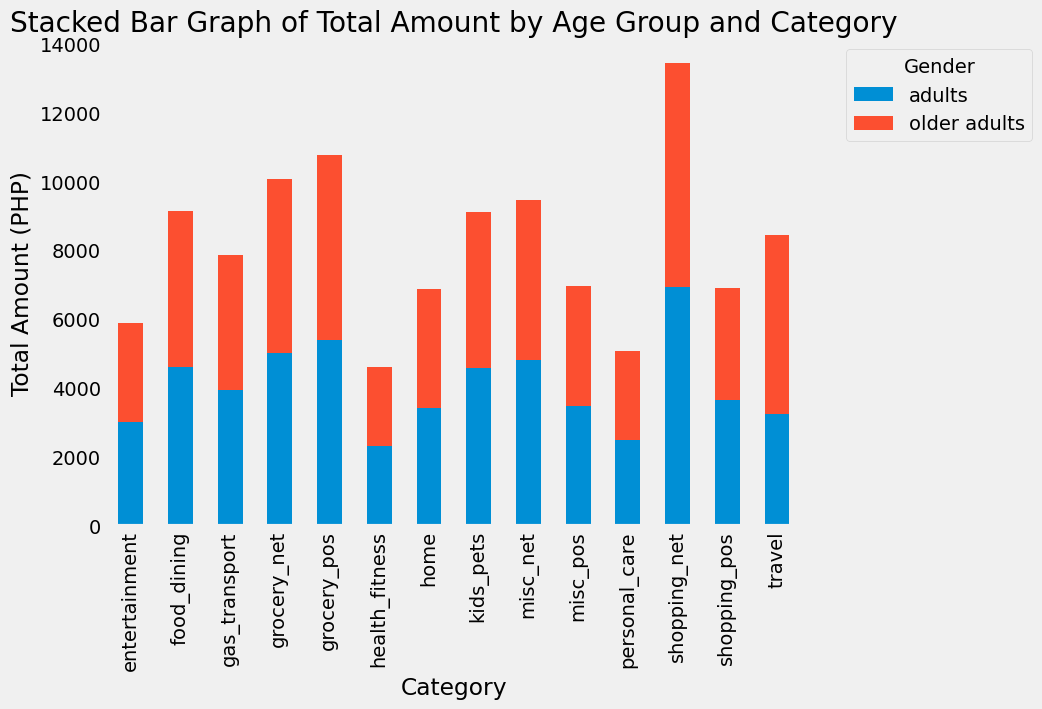

In [7]:
# Pivot the DataFrame to create a suitable format for a stacked bar plot
pivot_df = df_cleaned.pivot_table(index="category", columns="age_group", values="amt", fill_value=0)

# Create the stacked bar plot
pivot_df.plot(kind="bar", stacked=True, figsize=(8, 6))

# Add labels and title
plt.xlabel("Category")
plt.ylabel("Total Amount (PHP)")
plt.title("Stacked Bar Graph of Total Amount by Age Group and Category")

# Show the plot
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.tight_layout()
plt.show()

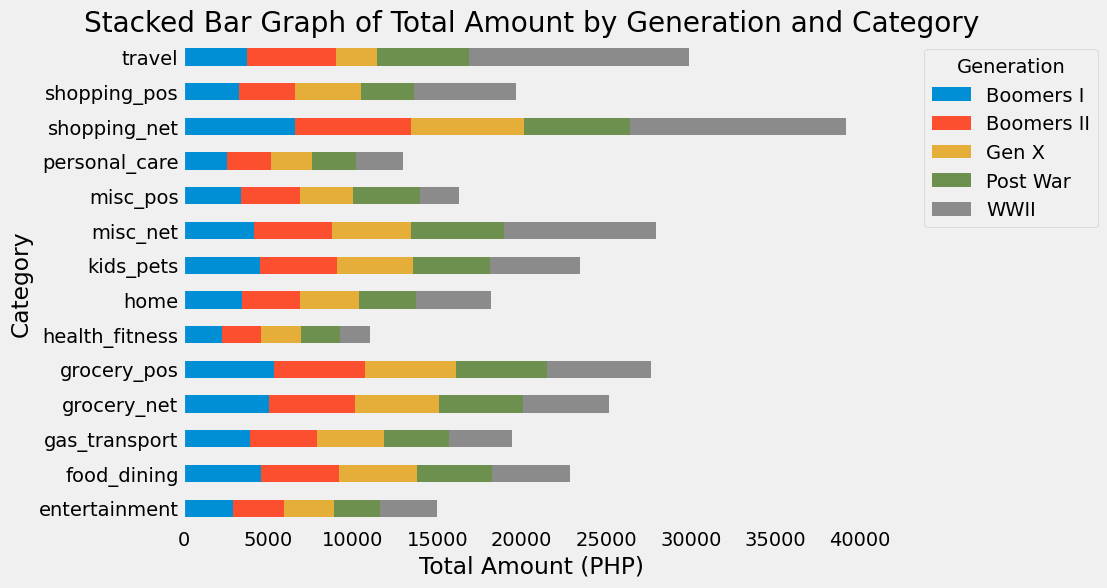

In [94]:
# Pivot the DataFrame to create a suitable format for a stacked bar plot
pivot_df = df_cleaned.pivot_table(index="category", columns="generation", values="amt", fill_value=0)

# Create the stacked bar plot
pivot_df.plot(kind="barh", stacked=True, figsize=(8, 6))

# Add labels and title
plt.ylabel("Category")
plt.xlabel("Total Amount (PHP)")
plt.title("Stacked Bar Graph of Total Amount by Generation and Category")

# Show the plot
plt.legend(title="Generation", bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.tight_layout()
plt.show()

# Save plots

# with respect to what?

In [9]:
display(pivot_df)

generation,Boomers I,Boomers II,Gen X,Post War,WWII
category,,,,,
entertainment,2904.970857,3025.373815,2948.399374,2745.863667,3371.914716
food_dining,4609.655268,4592.610459,4595.213481,4419.602209,4634.047132
gas_transport,3951.104614,3960.497420,3929.920660,3876.875247,3691.012815
grocery_net,5029.901756,5132.019905,4925.377993,4960.175819,5136.859450
grocery_pos,5369.700526,5367.155861,5391.118692,5382.434870,6122.346883
health_fitness,2294.821721,2293.489165,2345.261534,2293.435387,1822.509178
home,3480.213153,3406.173191,3489.022002,3355.841124,4428.497531
kids_pets,4501.459265,4598.965264,4499.108330,4507.204075,5340.751402
misc_net,4144.920066,4630.976069,4701.390403,5449.470483,9019.099479


In [10]:
daily_spendings = df_cleaned.pivot_table(index="trans_date", values="amt").sort_index()
daily_cases = covid.pivot_table(index="date", values="new_cases", aggfunc="sum").sort_index()
daily_spendings_cases = daily_spendings.merge(daily_cases, left_index=True, right_index=True)

In [11]:
display(daily_spendings_cases)

,amt,new_cases
2020-01-03,4533.055585,0.0
2020-01-04,4743.560204,0.0
2020-01-05,3229.463188,0.0
2020-01-06,4580.753197,0.0
2020-01-07,3457.690856,0.0
...,...,...
2021-12-02,3936.425647,564.0
2021-12-03,8332.441318,304.0
2021-12-04,4148.755517,395.0
2021-12-05,3341.612228,439.0


In [12]:
daily_spendings_cases.corr()

,amt,new_cases
amt,1.000000,0.040203
new_cases,0.040203,1.000000


Text(0.5, 1.0, 'Amount (PHP) vs New Cases')

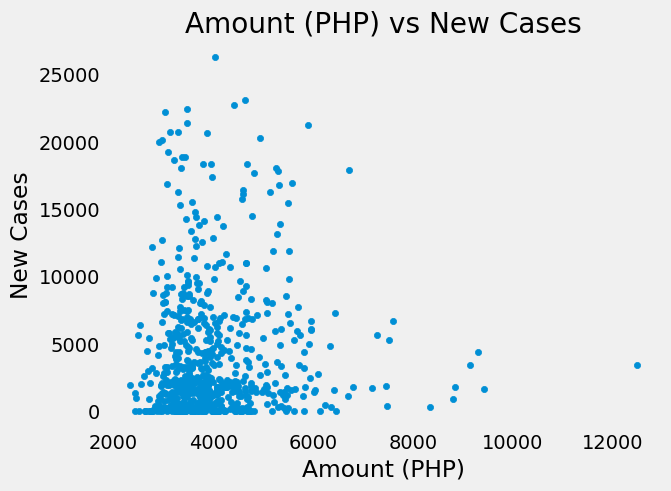

In [13]:
daily_spendings_cases.plot(kind='scatter', x='amt', y='new_cases')
plt.xlabel('Amount (PHP)')
plt.ylabel('New Cases')
plt.title('Amount (PHP) vs New Cases')

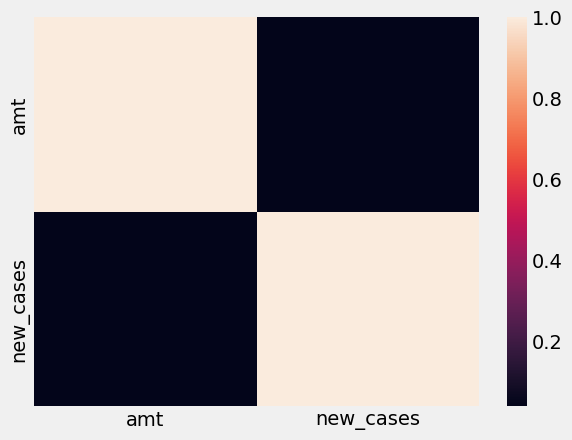

In [14]:
sns.heatmap(daily_spendings_cases.corr())
plt.show()

In [15]:
daily_spendings_cases[(daily_spendings_cases.amt == daily_spendings_cases.amt.max()) | (daily_spendings_cases.new_cases == daily_spendings_cases.new_cases.max())]

,amt,new_cases
2020-09-22,12476.048571,3439.0
2021-09-11,4022.290641,26238.0


In [16]:
daily_spendings_cases[(daily_spendings_cases.amt == daily_spendings_cases.amt.min())]

,amt,new_cases
2021-11-02,2334.916887,1954.0


In [17]:
# overall...maybe check location like ncr only?

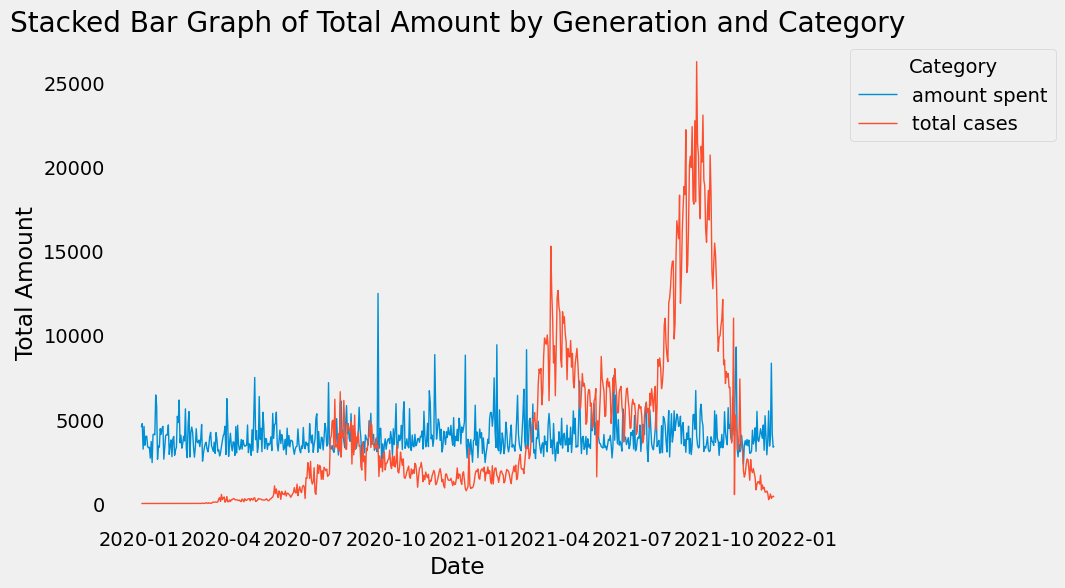

In [18]:
plt.figure(figsize=(8, 6))

plt.plot(daily_spendings_cases.index, daily_spendings_cases["amt"], label="amount spent", linewidth=1)
plt.plot(daily_spendings_cases.index, daily_spendings_cases["new_cases"], label="total cases", linewidth=1)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Total Amount")
plt.title("Stacked Bar Graph of Total Amount by Generation and Category")

# Show the plot
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.tight_layout()
plt.show()

In [43]:
df_cleaned.groupby([lambda x: df_cleaned['trans_date'][x].year, 'gender', 'category'])['amt'].agg(['sum', 'mean', 'median'])

sum         mean     median
     gender category                                            
2020 Female entertainment   7.423721e+05  2899.890823  1215.9480
            food_dining     1.137051e+06  4424.321358  3880.2378
            gas_transport   1.313677e+06  3980.838471  3920.2959
            grocery_net     3.077229e+05  5215.642627  5132.5506
            grocery_pos     1.654002e+06  5201.265277  4965.7839
            health_fitness  3.880522e+05  2204.841989  1135.2636
            home            1.171175e+06  3852.549264  3132.7707
            kids_pets       1.387604e+06  4505.207990  3874.5558
            misc_net        2.485301e+05  2239.010016   416.4906
            misc_pos        8.070565e+05  3806.870315   442.0596
            personal_care   6.102315e+05  2500.948601  1658.5758
            shopping_net    8.008716e+05  4974.358073   440.9232
            shopping_pos    7.436408e+05  2226.469584   346.0338
            travel          1.711884e+05  1438.558255   312.5100
     Male   entertainment   1.147202e+07  2887.496008  1186.9698
            food_dining     1.837685e+07  4594.213487  4036.7769
            gas_transport   2.083273e+07  3932.929903  3893.8746
            grocery_net     4.289129e+06  5057.934817  5046.7524
            grocery_pos     2.833576e+07  5374.764495  5093.0607
            health_fitness  6.523487e+06  2337.329686  1297.2006
            home            1.741285e+07  3408.937035  2682.1881
            kids_pets       2.285051e+07  4535.632026  3998.1393
            misc_net        7.525945e+06  4395.995794   439.5027
            misc_pos        1.183730e+07  3450.100795   475.0152
            personal_care   1.100180e+07  2573.521611  1627.3248
            shopping_net    1.747862e+07  6610.671753   515.9256
            shopping_pos    1.726423e+07  3320.044721   371.6028
            travel          8.435407e+06  4032.221251   318.7602
2021 Female entertainment   6.281457e+05  3341.200363  1183.8447
            food_dining     1.017918e+06  4524.079109  4008.0828
            gas_transport   9.657718e+05  3910.007339  3894.4428
            grocery_net     2.167143e+05  5285.715146  5404.1502
            grocery_pos     1.754052e+06  5586.151536  5058.1164
            health_fitness  3.760365e+05  2279.008876  1122.1950
            home            8.032337e+05  3137.631473  2288.9937
            kids_pets       1.279554e+06  4721.601523  4102.4040
            misc_net        2.098391e+05  2797.854680   383.5350
            misc_pos        5.140727e+05  2904.365536   449.4462
            personal_care   5.433998e+05  2663.724385  1581.0165
            shopping_net    8.585252e+05  6176.440282   485.2428
            shopping_pos    1.102603e+06  4053.689206   395.1831
            travel          2.476085e+05  2080.743625   282.9636
     Male   entertainment   1.052586e+07  2953.382913  1174.1853
            food_dining     1.667080e+07  4546.167425  3907.5114
            gas_transport   1.821463e+07  3933.196715  3899.5566
            grocery_net     3.965014e+06  4981.173840  4929.9873
            grocery_pos     2.448388e+07  5385.807939  5071.4691
            health_fitness  5.693082e+06  2269.064011  1181.2878
            home            1.531729e+07  3460.752147  2749.5198
            kids_pets       2.085034e+07  4545.528774  3975.1272
            misc_net        8.242564e+06  5328.095510   468.1968
            misc_pos        1.050726e+07  3523.562540   451.4349
            personal_care   9.202787e+06  2526.849833  1598.0625
            shopping_net    1.583071e+07  6922.043705   503.4252
            shopping_pos    1.671924e+07  3540.712549   366.4890
            travel          9.697681e+06  5244.824953   319.8966

In [20]:
df_cleaned.pivot_table(index='category', columns='gender', values='amt', aggfunc=['sum', 'mean', 'median'])

sum                       mean               \
gender                Female          Male       Female         Male   
category                                                               
entertainment   1.370518e+06  2.199788e+07  3086.751619  2918.651763   
food_dining     2.154968e+06  3.504765e+07  4470.888773  4571.233846   
gas_transport   2.279449e+06  3.904736e+07  3950.517345  3933.054359   
grocery_net     5.244372e+05  8.254143e+06  5244.372360  5020.768310   
grocery_pos     3.408054e+06  5.281964e+07  5392.490412  5379.877909   
health_fitness  7.640887e+05  1.221657e+07  2240.729192  2305.012973   
home            1.974409e+06  3.273014e+07  3525.729703  3432.991334   
kids_pets       2.667158e+06  4.370085e+07  4606.490628  4540.348533   
misc_net        4.583692e+05  1.576851e+07  2464.350606  4838.450001   
misc_pos        1.321129e+06  2.234456e+07  3396.219040  3484.259991   
personal_care   1.153631e+06  2.020459e+07  2575.069717  2552.051532   
shopping_net    1.659397e+06  3.330933e+07  5531.322830  6755.086203   
shopping_pos    1.846244e+06  3.398348e+07  3046.607764  3425.063214   
travel          4.187969e+05  1.813309e+07  1759.650940  4601.138847   

                   median             
gender             Female       Male  
category                              
entertainment   1184.9811  1181.2878  
food_dining     3945.5808  3981.3774  
gas_transport   3908.6478  3897.2838  
grocery_net     5272.6119  4999.3077  
grocery_pos     5026.2972  5083.6854  
health_fitness  1122.1950  1240.6647  
home            2703.4956  2709.4617  
kids_pets       4054.1070  3984.7866  
misc_net         411.3768   453.4236  
misc_pos         447.7416   464.2194  
personal_care   1615.9608  1608.5742  
shopping_net     469.3332   509.6754  
shopping_pos     361.0911   368.1936  
travel           306.2598   319.3284

In [90]:
# daily spendings per month
daily_spendings_cases.resample('M').agg({'amt' : ['count', 'sum', 'mean', 'median', 'max'], 'new_cases' : ['sum',]})

amt                                                         \
           count            sum         mean       median           max   
2020-01-31    29  112891.808004  3892.820966  4001.912026   6446.958620   
2020-02-29    29  114681.952389  3954.550082  3823.957590   6141.932458   
2020-03-31    31  107237.275002  3459.266936  3375.719029   4692.065279   
2020-04-30    30  112399.709499  3746.656983  3558.509158   6228.030143   
2020-05-31    31  126052.021606  4066.194245  3815.683114   7485.434434   
2020-06-30    30  108350.788724  3611.692957  3474.903555   5426.190630   
2020-07-31    31  120912.367976  3900.398967  3591.900196   7175.260673   
2020-08-31    31  123558.775901  3985.766965  3697.903453   6086.471935   
2020-09-30    30  122305.575671  4076.852522  3803.200786  12476.048571   
2020-10-31    31  121677.937083  3925.094745  3731.650308   6040.525391   
2020-11-30    30  130179.502684  4339.316756  3909.029452   8841.146177   
2020-12-31    31  129883.897617  4189.803149  4056.978325   8808.645748   
2021-01-31    31  122794.051232  3961.098427  3795.951590   7459.583261   
2021-02-28    28  112288.921689  4010.318632  3447.519083   9425.742703   
2021-03-31    31  128043.248364  4130.427367  3710.114174   9136.836161   
2021-04-30    30  114637.844355  3821.261479  3622.892242   5499.923467   
2021-05-31    31  124367.791157  4011.864231  3843.574836   7271.656789   
2021-06-30    30  119911.403968  3997.046799  3692.825127   7597.948008   
2021-07-31    31  126097.067709  4067.647345  3921.514086   5956.691829   
2021-08-31    31  131995.880611  4257.931633  4495.668332   5516.198594   
2021-09-30    30  119872.910824  3995.763694  3671.745746   6709.995963   
2021-10-31    31  134695.869444  4345.028047  3892.966495   9293.200671   
2021-11-30    30  114326.425651  3810.880855  3757.056459   5498.289691   
2021-12-31     6   26578.854783  4429.809130  3673.565525   8332.441318   

           new_cases  
                 sum  
2020-01-31       1.0  
2020-02-29       2.0  
2020-03-31    1543.0  
2020-04-30    6666.0  
2020-05-31    9012.0  
2020-06-30   19214.0  
2020-07-31   52853.0  
2020-08-31  128086.0  
2020-09-30   91891.0  
2020-10-31   69658.0  
2020-11-30   50931.0  
2020-12-31   42666.0  
2021-01-31   53091.0  
2021-02-28   50730.0  
2021-03-31  170923.0  
2021-04-30  290160.0  
2021-05-31  192863.0  
2021-06-30  182252.0  
2021-07-31  176412.0  
2021-08-31  400785.0  
2021-09-30  560182.0  
2021-10-31  237337.0  
2021-11-30   45280.0  
2021-12-31    2451.0

In [24]:
df_cleaned['city'].unique()

array(['Dasmarinas', 'Digos', 'Calapan', 'San Fernando', 'Laoag',
       'City of Paranaque', 'Balanga', 'Masbate', 'Malaybalay',
       'Antipolo', 'General Santos', 'Navotas', 'Marikina City',
       'Malabon', 'Palayan City', 'Naga City', 'Binan', 'Vigan', 'Mati',
       'Cadiz', 'Tacloban', 'Dagupan City', 'City of Isabela',
       'Cebu City', 'Batangas', 'Meycauayan', 'Muntinlupa City',
       'Olongapo', 'Sorsogon', 'Makati City', 'Angeles City',
       'City of Calamba', 'Pagadian', 'Tagbilaran City', 'Dumaguete City',
       'Santa Rosa', 'Butuan', 'San Pedro', 'Tuguegarao', 'Valenzuela',
       'Cabanatuan City', 'Maasin', 'Santiago', 'Manila', 'Lipa City',
       'Puerto Princesa', 'Caloocan City', 'San Jose del Monte', 'Imus',
       'San Juan', 'Dipolog', 'Legazpi City', 'Surigao', 'Iligan',
       'Talisay', 'Bacolod', 'Mandaluyong City', 'Iloilo', 'Lucena'],
      dtype=object)

In [75]:
# Which category of service/products have been purchased the most/least?
df_cleaned['category'].value_counts()

shopping_pos      10528
gas_transport     10505
grocery_pos       10450
kids_pets         10204
home              10094
personal_care      8365
food_dining        8149
entertainment      7981
misc_pos           6802
health_fitness     5641
shopping_net       5231
travel             4179
misc_net           3445
grocery_net        1744
Name: category, dtype: int64

In [49]:
# Does the type of service/product vary depending on location?
df_cleaned.groupby(['city', 'category'])['amt'].agg(['count'])

count
city         category            
Angeles City entertainment    157
             food_dining      190
             gas_transport    204
             grocery_net       34
             grocery_pos      220
...                           ...
Vigan        misc_pos         103
             personal_care    118
             shopping_net      72
             shopping_pos     148
             travel            56

[741 rows x 1 columns]

In [33]:
df_cleaned['city'].value_counts()[:15]

San Fernando       7143
Calapan            5562
Cadiz              5545
Masbate            5521
Dasmarinas         4742
Malaybalay         3993
Olongapo           3951
Pagadian           3936
Dumaguete City     3135
Mati               2399
Muntinlupa City    2392
Naga City          2391
City of Isabela    2389
Tagbilaran City    2388
Butuan             2386
Name: city, dtype: int64

In [70]:
# Dictionary of cities with missing categories
unique_cities = df_cleaned['city'].unique()
unique_categories = set(df_cleaned['category'].unique().tolist())

cities_with_incomplete_categories = {}

for city in unique_cities:
    city_data = df_cleaned[df_cleaned['city'] == city]
    missing_categories = unique_categories - set(city_data['category'].unique())
    if missing_categories:
        cities_with_incomplete_categories[city] = missing_categories

# display(cities_with_incomplete_categories)

{'Imus': {'entertainment',
  'food_dining',
  'grocery_net',
  'health_fitness',
  'home',
  'kids_pets',
  'misc_pos',
  'personal_care',
  'shopping_pos',
  'travel'},
 'San Juan': {'entertainment',
  'food_dining',
  'grocery_net',
  'health_fitness',
  'home',
  'kids_pets',
  'misc_pos',
  'personal_care',
  'shopping_pos'},
 'Dipolog': {'grocery_net', 'misc_net', 'travel'},
 'Legazpi City': {'entertainment',
  'food_dining',
  'gas_transport',
  'grocery_net',
  'health_fitness',
  'home',
  'kids_pets',
  nan,
  'personal_care',
  'travel'},
 'Surigao': {'entertainment',
  'food_dining',
  'gas_transport',
  'health_fitness',
  'home',
  'kids_pets',
  'misc_pos',
  'personal_care',
  'shopping_pos',
  'travel'},
 'Iligan': {'entertainment',
  'food_dining',
  'gas_transport',
  'grocery_net',
  'health_fitness',
  'home',
  'kids_pets',
  nan,
  'travel'},
 'Talisay': {'entertainment',
  'food_dining',
  'grocery_net',
  'health_fitness',
  'home',
  'kids_pets',
  'misc_pos',


In [71]:
data = [{'City': city, 'Incomplete Category': category} for city, categories in cities_with_incomplete_categories.items() for category in categories]
incomplete_categories_df = pd.DataFrame(data)
incomplete_categories_df.reset_index(drop=True, inplace=True)
display(incomplete_categories_df)

,City,Incomplete Category
0,Imus,grocery_net
1,Imus,personal_care
2,Imus,kids_pets
3,Imus,travel
4,Imus,health_fitness
...,...,...
85,Lucena,health_fitness
86,Lucena,NaN
87,Lucena,home
88,Lucena,misc_pos


In [73]:
# List of cities with incomplete categories
incomplete_categories_df.City.unique()

array(['Imus', 'San Juan', 'Dipolog', 'Legazpi City', 'Surigao', 'Iligan',
       'Talisay', 'Bacolod', 'Iloilo', 'Lucena'], dtype=object)

In [80]:
# Which city has the highest spenders?
df_cleaned.groupby('city')['amt'].agg(['max', 'mean', 'median', 'sum', 'count']).sort_values(by='count', ascending=False)

,max,mean,median,sum,count
city,,,,,
San Fernando,2.315114e+05,3777.940720,2653.4940,2.698583e+07,7143
Calapan,1.585948e+05,3799.805933,2804.3511,2.113452e+07,5562
Cadiz,3.588234e+05,3888.952010,2783.0436,2.156424e+07,5545
Masbate,5.867648e+05,4084.173847,2767.1340,2.254872e+07,5521
Dasmarinas,3.667845e+05,3996.383176,2833.0452,1.895085e+07,4742
Malaybalay,1.103206e+05,3875.534817,2789.8620,1.547501e+07,3993
Olongapo,9.383124e+05,3910.322343,2753.4972,1.544968e+07,3951
Pagadian,8.363574e+05,4420.448320,2916.2865,1.739888e+07,3936
Dumaguete City,5.454976e+05,4124.099272,2849.5230,1.292905e+07,3135


In [ ]:
# sns.catplot(data=df_cleaned, kind='count', x='city')

In [ ]:
# sns.relplot(data=df_cleaned, x='trans_date', y='amt', hue='category', col='gender')

In [ ]:
# outliers..

In [ ]:
# sns.boxplot(data=df_cleaned, x='amt', y='gender', sym="")

In [ ]:
# sns.set_style('dark')

# sns.catplot(data=df_cleaned, x="amt", y="gender", kind="violin")

In [ ]:
# marimekko chart